In [1]:
import warnings
import pyslim, tskit, msprime
from IPython.display import SVG
import numpy as np
import matplotlib.pyplot as plt

ts = tskit.load("example_sim.trees")

```{eval-rst}
.. currentmodule:: pyslim
```

# Time units

There are a number of subtle ways that time units can trip up the user;
below are explanations of how to deal with most of these topics.
At issue is the fact that tree sequences produced by SLiM
have times in units of "ticks", rather than generations. 
If we query such a tree sequence for its time units we see 
its return value

In [2]:
ts.time_units

'ticks'

In general this mean it can be conceptually tricky to make sure that time units
are consistent across different stages of simulation.

(Note: it *is* possible to set the time units to whatever you want,
using the ``timeUnit`` parameter to ``initializeTreeSeq( )``,
but this only affects this label in metadata (i.e., the output of
``ts.time_units``, and does not actually change how times are recorded
in the tree sequence.)


## Mutation rates with msprime

Only you really know how much time in the real world
corresponds to one spin around SLiM's life cycle.
one spin around SLiM's life cycle corresponds to.
So, SLiM does not specify what its time units actually are,
and refers to them as "ticks".
Previous versions of SLiM called these "generations",
but this is only correct for simulations in which all organisms die every tick.
Converting these times into real-world times is usually not too hard:
maybe in your simulation one tick = one year,
or maybe you need to multiply by a (mean) generation time known from empirical data.

However, it becomes important to know what the time units are
when interfacing with msprime.
For instance, suppose you've done a WF simulation for an organism whose mean generation time
in the real world is 30 years, and you want to overlay neutral mutations using msprime.
The mutation rate passed to msprime is in units of mutations per unit-of-time-in-the-tree-sequence,
so since you did a WF simulation, the units of time in the tree sequence are in generations,
and you should give it mutation rate in mutations per generation.
The rate in units of mutations per year would be 30 times smaller,
and so would give you 30 times fewer neutral mutations than you want.
Conversely, if you did a nonWF simulation where one tick = one year,
then you'd want the mutation rate in units of mutations per year.

## Coalescence, recombination, and migration rates in recapitation

If you recapitate with msprime, then the same issue occurs for coalescence rates.
This is less obvious, because "coalescence rate" is not an argument to msprime;
rather, the coalescence rate in a given population
is {math}`1/2N`, where {math}`N` is the (effective) size of that population.
(The 2 in the denominator is actually the 'ploidy' argument to msprime, which defaults to 2.)
This is the correct rate, *in units of coalescences per generation*.
Since it's "per generation", this means that if you want to recapitate a tree sequence
generated by SLiM in which one tick is not one generation,
then **you need to adjust the effective population sizes accordingly**.
For instance, suppose as above that we did a nonWF simulation
in which one tick = one year, for a species with generation time 30 years,
and we want to recapitate with an effective size of 10,000 diploids.
An effective size of 10,000 diploids means one coalescence per pair of lineages
every 20,000 generations;
since one unit of time in the tree sequence equals 1/30th of a generation,
this is one coalescence per pair of lineages every 600,000 time units,
which we can get msprime to do by asking for an effective population size of 300,000.
In other words, if a generation in our tree sequence is {math}`T` units of time,
then we need to divide the coalescence rate by {math}`T,`
which we do by multiplying effective population sizes by {math}`T`.

(A better way of thinking about this could be to say that since the mean time to coalescence
is twice the effective population size,
actually effective population size is in units of *time*, rather than individuals.)

To recapitate we need to also pick recombination and (possibly) migration rates.
Since these are rates, they are also in units of something "per time",
and so just as for mutation rates, we need to ensure they are in the correct units.
Recombination rates in particular come in units of "per generation"
(since a Morgan is in units of recombinations per generation),
and so a rate of {math}`r` Morgans would need to be divided by {math}`T`
before it's passed to msprime for recapitation.
Since msprime (by default) runs a continuous-time simulation,
there is no harm in adjusting time units in msprime this way,
but it is confusing.


### `TimeUnitsMismatchWarning`

Above we saw that if we want msprime to simulate coalescence in a population of size 10,000
to recapitate our tree sequence whose times are given in units of 1/30th of a generation, 
then we need to ask it for a population of (effective) size 300,000.
In other words, the "population sizes" of msprime are *only* in units of individuals
(as one would expect a population size to be)
*if* times are being measured in units of generations.
For this reason, although it's not strictly true,
sometimes we say that "msprime times are in units of generations".
Also, msprime will produce a warning if it is handed a tree sequence
whose time units are not "generations":

In [3]:
rts = pyslim.recapitate(ts,
            recombination_rate=1e-8,
            ancestral_Ne=200, random_seed=5)

/opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/msprime/ancestry.py:831: TimeUnitsMismatchWarning: The initial_state has time_units=ticks but time is measured in generations in msprime. This may lead to significant discrepancies between the timescales. If you wish to suppress this warning, you can use, e.g., warnings.simplefilter('ignore', msprime.TimeUnitsMismatchWarning)
  warnings.warn(message, TimeUnitsMismatchWarning)


In [4]:
import textwrap
with warnings.catch_warnings(record=True) as w:
    rts = pyslim.recapitate(ts,
                recombination_rate=1e-8,
                ancestral_Ne=200, random_seed=5)
    print("\n".join(textwrap.wrap(f"TimeUnitsMismatchWarning: {str(w[0].message)}", width=90)))

generations in msprime. This may lead to significant discrepancies between the timescales.
If you wish to suppress this warning, you can use, e.g., warnings.simplefilter('ignore',
msprime.TimeUnitsMismatchWarning)


Think of this warning as a friendly reminder to pay attention to your time units.
To make this warning disappear, the easiest option is to do as the warning suggests
and just ask python to ignore it:

In [5]:
import warnings
warnings.simplefilter('ignore', msprime.TimeUnitsMismatchWarning)
rts = pyslim.recapitate(ts,
            recombination_rate=1e-8,
            ancestral_Ne=200, random_seed=5)

To re-label the time units on your tree sequence
as being in "generations" (but! only do this if it's true!),
you must convert to a TableCollection and back (since the tables are mutable
but the tree sequence is not):

In [6]:
print(f"Time units before: {ts.time_units}")
t = ts.dump_tables()
t.time_units = 'generations'
ts = t.tree_sequence()
print(f"Time units after: {ts.time_units}")

Time units before: ticks
Time units after: generations


## Example: calculating generation times in a SLiM simulation

In a nonWF simulation, the generation time is not something that you get to explicitly set:
rather, like population size it is an emergent property of the rules of the simulation.
So, it's important to be able to calculate what the (average) generation time actually is
in a given simulation (keeping in mind that the answer may vary across time and space).
This is not really a pyslim operation at all,
but since it's important to the considerations above,
here's an easy way to do this.
The definition of generation time appropriate for comparison to a coalescent simulation
is "average amount of time between birth of parent and birth of child".
(Note that this is the birth of the *average* child in some sense,
not the average time to each parent's first child!)
Therefore,
an easy and convenient way to measure this is to
record for each individual their parents' ages at the times of their births,
and then take the average across all individuals alive at a given time.
(This is only one possible choice,
and other choices are usually but not always equivalent,
but a discussion of the options and distinctions
would make this tutorial lengthy and confusing.

Here is a script that computes this.
In the simulation, females' fecundity increases with their age,
and so we expect "generation time" to be larger than the mean age of individuals
alive at a given time.
In the script, we store the average of the mean parent ages across all 
extant individuals every tick using SLiM Individuals' `meanParentAge` property, 
and store the vector in top-level metadata when we write out the tree sequence.

```{literalinclude} generation_time.slim
```

In [7]:
%%bash
slim -s 23 generation_time.slim | tail -n1

#WARNING (Species::RunInitializeCallbacks): with tree-sequence recording enabled and a non-zero mutation rate, a neutral mutation type was defined and used; this is legal, but usually undesirable, since neutral mutations can be overlaid later using the tree-sequence information.


Done! Mean generation time 2.49543


(About the warning: we turned on mutations for a good reason; see below.)
Now we can look at our empirical calculation of generation time.
Note that the first generation individuals have a mean parent age of 0.0,
so we expect generation time to go up at first.

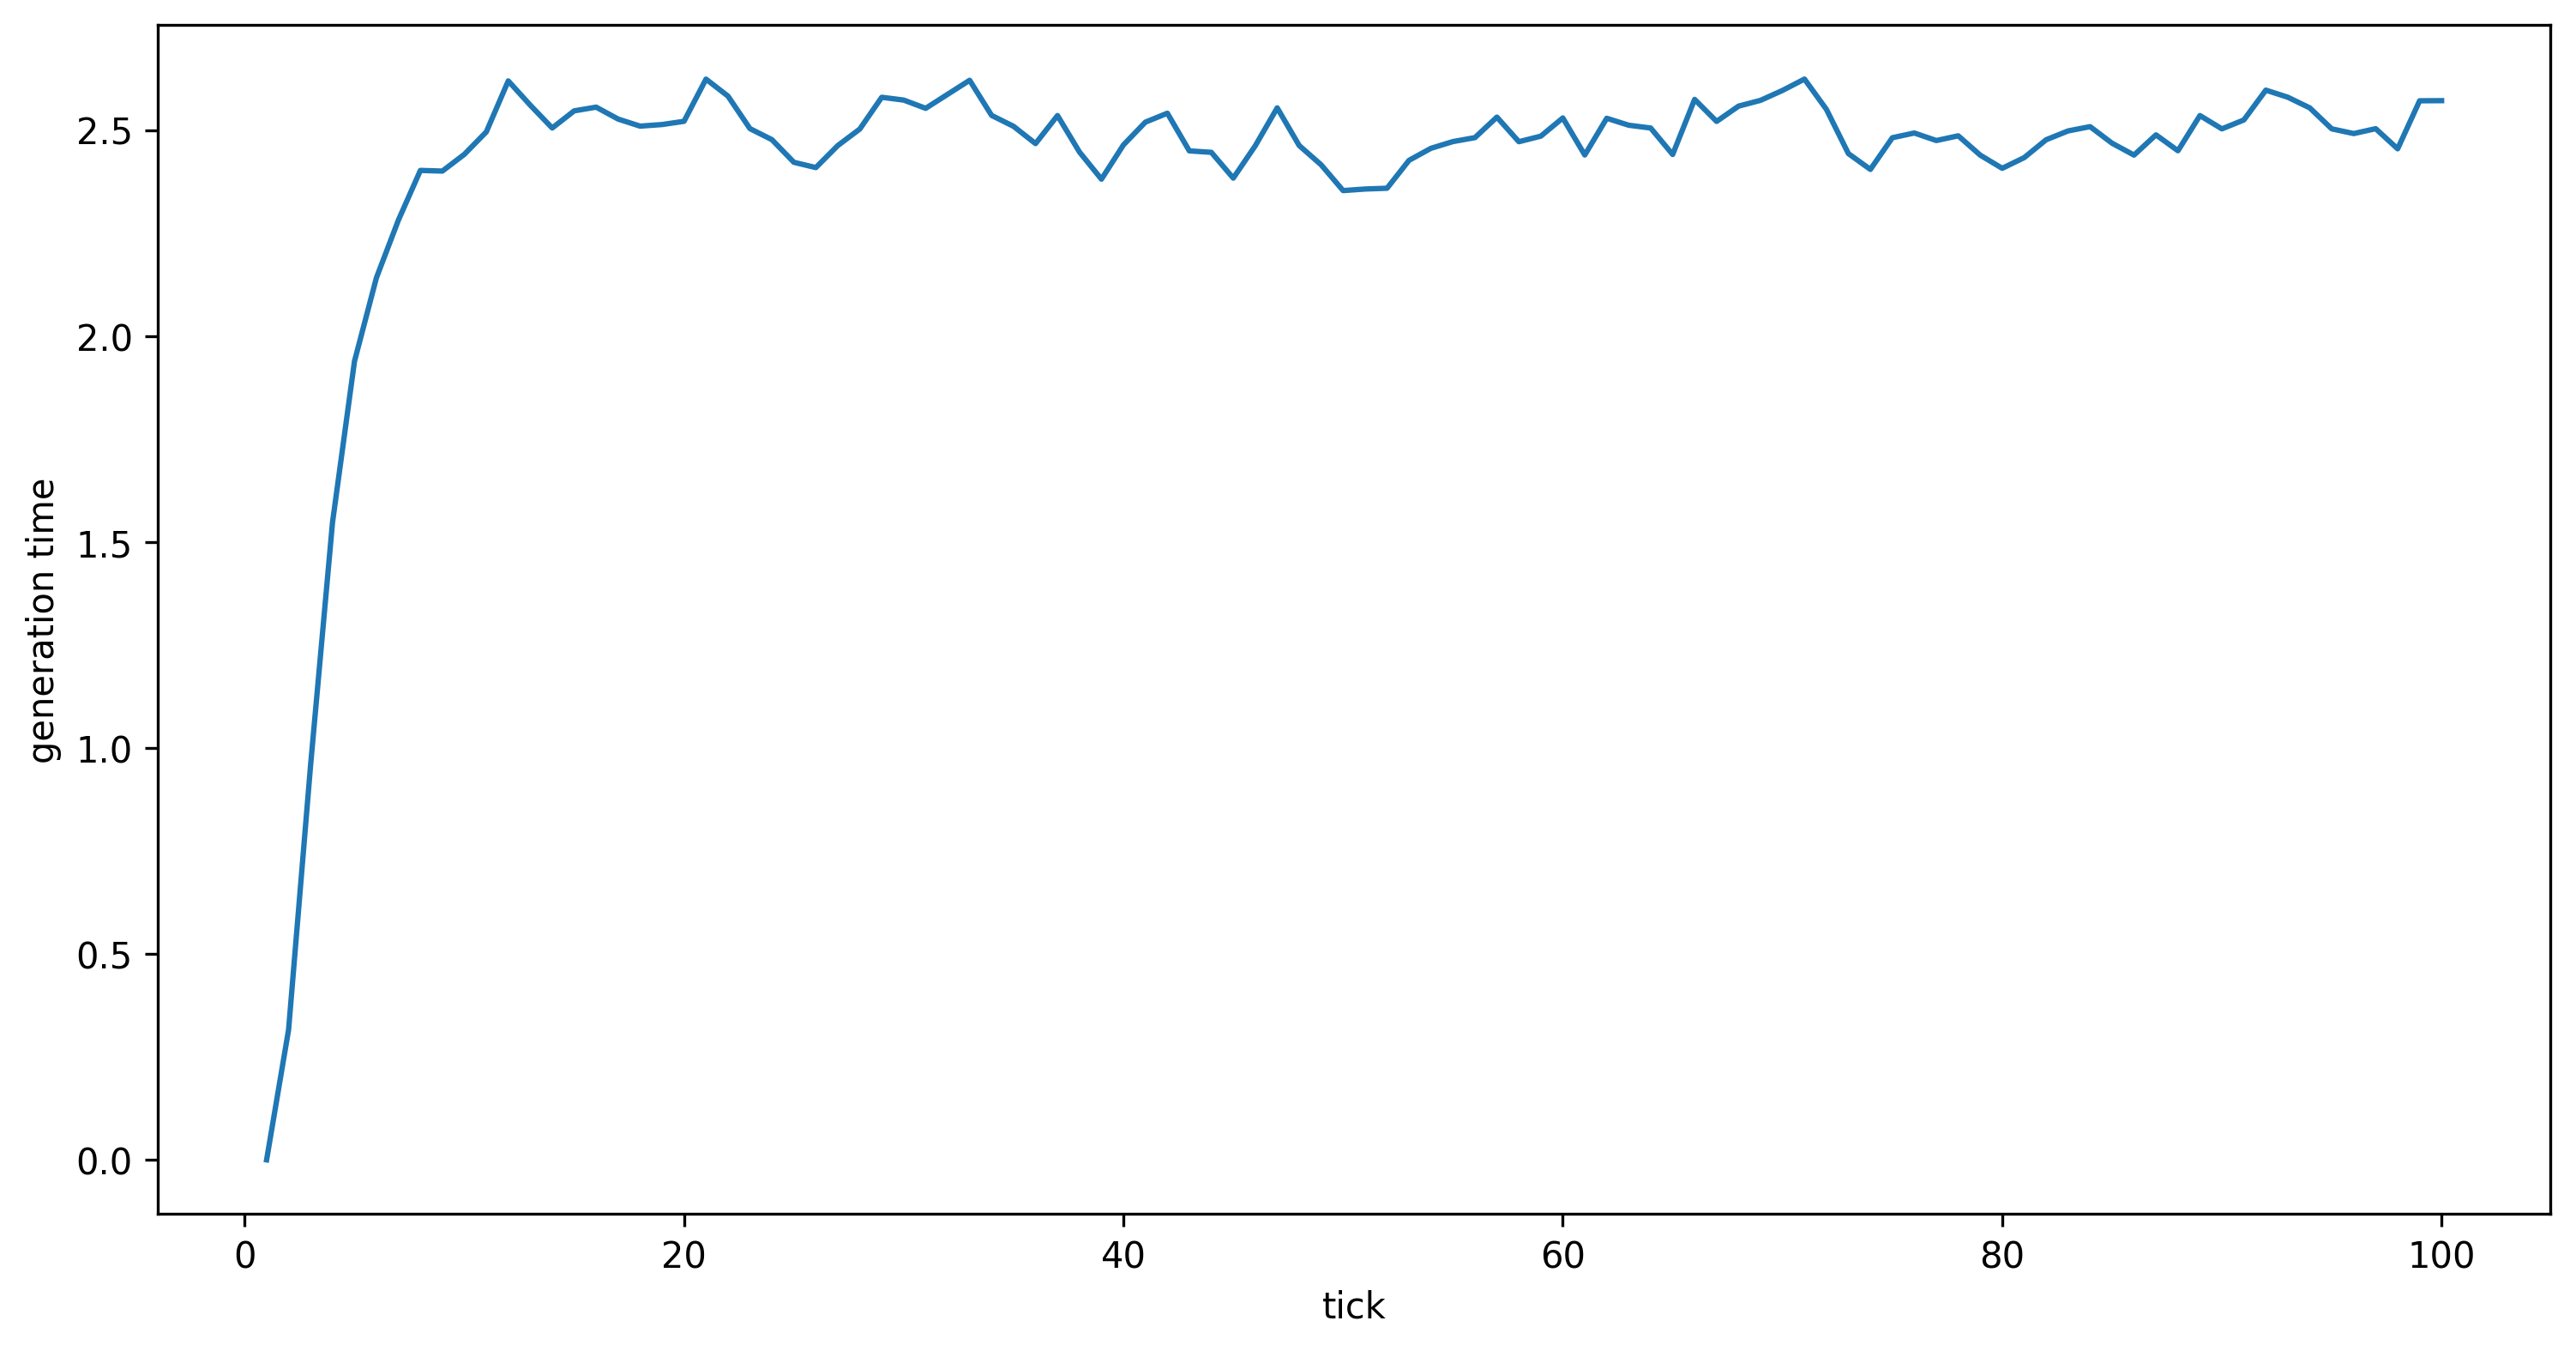

In [8]:
gts = tskit.load("generation_time.trees")
gentimes = gts.metadata["SLiM"]["user_metadata"]["generation_times"]

fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
ax.set_xlabel("tick")
ax.set_ylabel("generation time")
ax.plot(np.arange(1, len(gentimes)+1), gentimes);

In the script above we added mutations during the SLiM simulation to do a simple check 
to verify the `meanParentAge` property correctly estimates mean generation time. 
If it does, then the mean sequence divergence calculated from the mutations introduced by SLiM
should (approximately) match the mean length of branches in the tree sequence separating two samples
multiplied by the expected number of mutations per unit time.
(We get the mean branch length using the {meth}`ts.diversity <tskit.TreeSequence.diversity>` method with ``mode="branch"``;
see the [tskit documentation](tskit:sec_stats) for details.)
This involves the generation time because "mutations per unit time" is equal to
"mutations per generation" (here, the mutation rate per bp, {math}`10^{-8}`)
divided by "time per generation" (i.e., mean generation time).

In [9]:
slim_diversity = gts.diversity(mode = 'site')
ts_diversity = gts.diversity(mode='branch') * 1e-8 / np.mean(gentimes)

print(f"slim diversity: {slim_diversity}\n"
      f"scaled tree sequence diversity: {ts_diversity}\n"
      f"error: {100 * np.abs(slim_diversity - ts_diversity)/slim_diversity:0.3f}%"
)

slim diversity: 1.5383378037734143e-06
scaled tree sequence diversity: 7.966231965147045e-07
error: 48.215%


Now, to recapitate this simulation
in a population with effective size 1000,
and using the recombination rate from the SLiM script of {math}`10^{-8}`
crossovers per generation
and {math}`2 \times 10^{-8}` mutations per generation,
we need to scale {math}`N_e` and both rates by the generation time.
Furthermore, since we already have mutations up until 100 time units ago,
we need to put mutations on only previous to that time.

In [10]:
gentimes = gts.metadata["SLiM"]["user_metadata"]["generation_times"]
gt = np.mean(gentimes[-50:])
recomb_rate = 1e-8 # per generation
Ne = 1000 # generations
mut_rate = 2e-8 # per generation
with warnings.catch_warnings(record=True) as w:
    rts = pyslim.recapitate(gts,
                recombination_rate=recomb_rate / gt,
                ancestral_Ne=Ne * gt,
                random_seed=5)
    mts = msprime.sim_mutations(
               rts,
               rate=mut_rate / gt,
               model=msprime.SLiMMutationModel(type=0),
               keep=True,
               start_time=100,
    )

print(f"Mean genetic diversity is now {mts.diversity():.2e},\n"
      f"  and the expected value under a WF model is "
      f"4 * N * mu = {4 * Ne * mut_rate:.2e}")

Mean genetic diversity is now 5.30e-05,
  and the expected value under a WF model is 4 * N * mu = 8.00e-05


We get a lower value of genetic diversity than expected under a WF model,
but that's expected because both fluctuating population sizes
and age-associated variability in fecundity will decrease the effective population size.


(sec_metadata_converting_times)=

## Converting from SLiM time to tskit time and back

:::{note}
This is a nitpicky, document-the-details section.
Hopefully, you don't have to deal with the specifics of converting between tskit and SLiM time,
but this page is here for you if you do.
:::

SLiM is a forwards simulator, while the tree sequence format thinks about things
*retrospectively*, and so works with times in units of *time ago*.
Mostly, you don't have to convert between the two,
unless you want to match up information in a tree sequence
with information written out by SLiM itself.
In other words, SLiM's time counter measures the number of time steps
("ticks") since the start of the simulation,
and times in the tree sequence record how long before the end of the simulation.
However, there are quite a few details, and off-by-one errors are easy to make,
so we'll spell it out here.
Hopefully, you can just use pyslim's methods
{func}`.slim_time`, {func}`.individuals_alive_at`,
and {func}`.individual_ages_at`
without needing to actually do any conversions yourself.

SLiM's time counter is called the "tick".
The SLiM tick starts at 1, and records which round of the life cycle the simulation is in.
However, the order of the life cycle differs between WF and nonWF models:
in a WF model, it is *first* {math}`\to` *early* {math}`\to` *birth* {math}`\to` *late*",
while in a nonWF model, it is *first* {math}`\to` *birth* {math}`\to` *early* {math}`\to` *late*.
Often, the first set of individuals are created in the *early()* phase of tick 1,
and so in a WF model reproduce immediately, in the same tick they were "born".
Parents and offspring cannot have the same birth time in the tree sequence,
and so some clever bookkeeping was required.
You'll want to refer to the tables below to see what's going on.
"Time" in a tree sequence is actually *time ago*,
or *time before the tree sequence was recorded*.
To obtain this number, and ensure that offspring cannot have the same birth time-ago
in the tree sequence as their parents,
SLiM also keeps track of "how many birth phases of the life cycle have happened so far"
(the column "# births" in the tables).
As the simulation goes along,
tskit time ago is recorded as minus one times the number of birth phases so far.
(We multiply by -1 because as we move forward in time,
we accumulate a negative number of "time-ago" units.)
When the tree sequence is output, the current cumulative number of birth phases
is added to this,
so "tskit time ago" is, equivalently, "how many birth phases happened since this time".
In a nonWF model, the two counters ("tick" and "number of birth phases")
are always in sync; but in a WF model they are not (during *first* and *early*).
The extra wrinkle this introduces is that the correspondence between "tskit time ago"
and "SLiM time" depends on *which phase the tree sequence was recorded in*.

When the tree sequence is written out, SLiM records the value of its current tick
and the current stage,
which can be found in the metadata: ``ts.metadata['SLiM']['tick']``,
and ``ts.metadata['SLiM']['stage']``.
The "SLiM time" referred to by a ``time`` in the tree sequence
(i.e., the value that would be reported by ``community.tick``
within SLiM at the point in time thus referenced)
can be obtained by subtracting ``time`` from ``ts.metadata['SLiM']['tick']``
and possibly adding or subtracting one depending on the current stage.
The fiddly details are worked out by the {func}`.slim_time` method,
which takes a ``stage`` argument.

Some of the other methods in pyslim -- those that depend on {func}`.individuals_alive_at`
-- need you to tell them during which stage the tree sequence was saved with ``sim.treeSeqOutput``,
and need this to be the same as the stage that any individuals were saved with ``sim.treeSeqRememberIndividuals``.
(This can add another factor of plus or minus one to the calculations.)
This argument, ``remembered_stage``, defaults to *late()*;
we recommend that you also default to always Remembering individuals, and saving out the tree sequence,
during *late()* as well, unless you have good reason not to.

### Detailed description of conversion


To help keep all this straight, here are schematics for WF and nonWF models.
(To see the nonWF model schematic, click on the "nonWF" tab.)

```{tabbed} WF model

For a WF model, the SLiM tick (first column) can be obtained by subtracting the
tskit time ago from the SLiM tick at time of output only during the same stage that output occured in.
Suppose that we want to know what tick counter in SLiM corresponds to a given tskit time ago.
The answer to this depends on what stage, unfortunately.
Let {math}`k` be the value of the tick counter, {math}`n` be the total number of ticks,
i.e., the value of ``ts.metadata["SLiM"]["tick"]``,
{math}`t` be the tskit time,
{math}`x=1` if the stage is *first()* or *early()* and 0 otherwise,
and {math}`y=1` if the tree sequence was output in *late()*.
Then, as can be verified from the table below, {math}`k + t = n + x + y - 1`.
The right-hand columns show {math}`t`, i.e.,
what the **tskit time ago** is at the corresponding point in the SLiM simulation.

|    tick            |       stage         |  # births          |                                |  ``first`` output         |  ``early`` output         |   ``late`` output |
|--------------------|---------------------|--------------------|--------------------------------|---------------------------|---------------------------|-------------------|
|       1            |       first         |       0            | {math}`\leftarrow` add subpops |        n-1                |        n-1                |         n         |
|       1            |       early         |       0            |                                |        n-1                |        n-1                |         n         |
|       1            |       birth         |       1            |                                |        n-2                |        n-2                |         n-1       |
|       1            |       late          |       1            |                                |        n-2                |        n-2                |         n-1       |
|       2            |       first         |       1            |                                |        n-2                |        n-2                |         n-1       |
|       2            |       early         |       1            |                                |        n-2                |        n-2                |         n-1       |
|       2            |       birth         |       2            |                                |        n-3                |        n-3                |         n-2       |
|       2            |       late          |       2            |                                |        n-3                |        n-3                |         n-2       |
|       3            |       first         |       2            |                                |        n-3                |        n-3                |         n-2       |
|       3            |       early         |       2            |                                |        n-3                |        n-3                |         n-2       |
|       3            |       birth         |       3            |                                |        n-4                |        n-4                |         n-3       |
|       3            |       late          |       3            |                                |        n-4                |        n-4                |         n-3       |
| {math}`\downarrow` | {math}`\cdots`      | {math}`\downarrow` |                                | {math}`\uparrow`          | {math}`\uparrow`          | {math}`\uparrow`  |
|       n-2          |       first         |       n-3          |                                |        2                  |        2                  |         2         |
|       n-2          |       early         |       n-3          |                                |        2                  |        2                  |         2         |
|       n-2          |       birth         |       n-2          |                                |        1                  |        1                  |         2         |
|       n-2          |       late          |       n-2          |                                |        1                  |        1                  |         2         |
|       n-1          |       first         |       n-2          |                                |        1                  |        1                  |         2         |
|       n-1          |       early         |       n-2          |                                |        1                  |        1                  |         2         |
|       n-1          |       birth         |       n-1          |                                |        0                  |        0                  |         1         |
|       n-1          |       late          |       n-1          |                                |        0                  |        0                  |         1         |
|       n            |       first         |       n-1          |  treeSeqOutput {math}`\to`     |        0                  |        0                  |         1         |
|       n            |       early         |       n-1          |                                | treeSeqOutput {math}`\to` |        0                  |         1         |
|       n            |       birth         |       n            |                                |                           |                           |         0         |
|       n            |       late          |       n            |                                |                           | treeSeqOutput {math}`\to` |         0         |

```

```{tabbed} nonWF model

Note that for nonWF models the SLiM time (first column) can always be obtained by subtracting the
tskit time ago from the SLiM time at time of output.
Suppose that we want to know what tick counter in SLiM corresponds to a given tskit time ago.
The answer to this depends on what stage, unfortunately.
Let {math}`k` be the value of the tick counter, {math}`n` be the total number of ticks,
i.e., the value of ``ts.metadata["SLiM"]["tick"]``,
let {math}`t` be the tskit time,
{math}`x=1` if the stage is "first" and 0 otherwise,
and {math}`y=1` if the tree sequence was output in *early()* or *late()*.
Then, as can be verified from the table below, {math}`k + t = n + x + y - 1`.
The right-hand columns show {math}`t`, i.e.,
what the **tskit time ago** is at the corresponding point in the SLiM simulation.

|    tick            |       stage         |  # births          |                                |  first output              |  early output              |   late output    |
|--------------------|---------------------|--------------------|--------------------------------|----------------------------|----------------------------|------------------|
|       1            |       first         |       0            | {math}`\leftarrow` add subpops |        n-1                 |        n                   |         n        |
|       1            |       birth         |       1            |                                |        n-2                 |        n-1                 |         n-1      |
|       1            |       early         |       1            | {math}`\leftarrow` add subpops |        n-2                 |        n-1                 |         n-1      |
|       1            |       late          |       1            |                                |        n-2                 |        n-1                 |         n-1      |
|       2            |       first         |       1            |                                |        n-2                 |        n-1                 |         n-1      |
|       2            |       birth         |       2            |                                |        n-3                 |        n-2                 |         n-2      |
|       2            |       early         |       2            |                                |        n-3                 |        n-2                 |         n-2      |
|       2            |       late          |       2            |                                |        n-3                 |        n-2                 |         n-2      |
|       3            |       first         |       2            |                                |        n-3                 |        n-2                 |         n-2      |
|       3            |       birth         |       3            |                                |        n-4                 |        n-3                 |         n-3      |
|       3            |       early         |       3            |                                |        n-4                 |        n-3                 |         n-3      |
|       3            |       late          |       3            |                                |        n-4                 |        n-3                 |         n-3      |
| {math}`\downarrow` | {math}`\cdots`      | {math}`\downarrow` |                                | {math}`\uparrow`           | {math}`\uparrow`           | {math}`\uparrow` |
|       n-2          |       first         |       n-3          |                                |        2                   |        3                   |         3        |
|       n-2          |       birth         |       n-2          |                                |        1                   |        2                   |         2        |
|       n-2          |       early         |       n-2          |                                |        1                   |        2                   |         2        |
|       n-2          |       late          |       n-2          |                                |        1                   |        2                   |         2        |
|       n-1          |       first         |       n-2          |                                |        1                   |        2                   |         2        |
|       n-1          |       birth         |       n-1          |                                |        0                   |        1                   |         1        |
|       n-1          |       early         |       n-1          |                                |        0                   |        1                   |         1        |
|       n-1          |       late          |       n-1          |                                |        0                   |        1                   |         1        |
|       n            |       first         |       n-1          |  treeSeqOutput {math}`\to`     |        0                   |        1                   |         1        |
|       n            |       birth         |       n            |                                |                            |        0                   |         0        |
|       n            |       early         |       n            |                                |  treeSeqOutput {math}`\to` |        0                   |         0        |
|       n            |       late          |       n            |                                |                            | treeSeqOutput {math}`\to`  |         0        |

```